In [1]:
%%capture
"""
-----------------------------------------------------------------------------------------------------------------------------------------------------------
This file is used to train a NODE to fit the data for 2 masses on springs experiment.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
"""

In [2]:
%%capture
%%bash 
pip install torchdiffeq

In [3]:
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [37]:
parser = argparse.ArgumentParser()
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--niters', type=int, default=100)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')
args = parser.parse_args(args=[])

args.niters = 5000
args.lr = 1e-2
args.nhidden = 10
args.test_freq = 20
args.viz = True
args.adjoint = False
args.method = 'dopri5'

In [5]:
adjoint = False

if args.adjoint == True:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [6]:
%%capture
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)
        
if args.viz:
    makedirs('png')
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12, 4), facecolor='white')    

In [7]:
class OscillatorsDataset(Dataset):
    """
    Dampled Coupled Oscillators synthetic dataset.
    For full details, see damped_oscillators_data.ipynb.
    The code is replicated here to allow imports of the DataLoaders from saved experiments.
    """
    
    def __init__(self, config, train=True, verbose=True):

        # from config
        #   base simulator setup
        self.dt = config['simulator']['dt']
        self.freq = config['simulator']['sampling_freq']
        self.samples = config['simulator']['samples']
        #   system parameter dictionaries
        self.fixed = config['fixed']
        if train:
            self.varying = config['varying']
            self.n = config['train_examples']
        else:
            self.varying = config['eval_varying']
            self.n = config['eval_examples']
        
        # + 1 for the extra sample at t = 0
        self.total_steps = self.freq*self.samples + 1
        # normalised times
        self.times = torch.arange(0,self.samples+1,1)/(1.*self.samples)
        
        if verbose:
            if train:
                print('Training data generation...')
            else:
                print('Evaluation data generation...')
            print('Fixed paramters', self.fixed)
            print('Varying parameters', self.varying)
        
        self.data = []
        # generate data
        for _ in range(self.n):
            description, conditions = self.description_and_conditions()
            output = self.single_run(conditions)
            self.data.append((description, output, self.times))
        
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return self.n
    
    def description_and_conditions(self):
        """
        Return a sample of initial conditions, with those specified at
        input being fixed and the unspecified being the description, too.
        """
        
        conditions = deepcopy(self.fixed)
        for key in self.varying:
            if key in conditions:
                warnings.warn('System parameter defined in both fixed and varying configs')
            low = min(self.varying[key])
            high = max(self.varying[key])
            conditions[key] = np.random.uniform(low,high)
        
        # the description is the varying part
        description = [conditions[v] for v in self.varying]
        
        return torch.FloatTensor(description), conditions
    
    def single_run(self, conditions):
        x1, x2 = conditions['x1'], conditions['x2']
        v1, v2 = conditions['v1'], conditions['v2']
        m1, m2 = conditions['m1'], conditions['m2']
        c, k = conditions['c'], conditions['k']
        output = []
        for step in range(self.total_steps):
            if step % self.freq == 0:
                output.append([x1,x2,v1,v2])          #Can get rid of v1 and v2 here if I don't care about velocity.
            
            a1 = k*(x2-2*x1) - c*v1
            a2 = k*(x1-2*x2) - c*v2
            
            x1 += self.dt*v1
            x2 += self.dt*v2
            v1 += self.dt*a1
            v2 += self.dt*a2
    
        return torch.FloatTensor(output)

In [8]:
def visualize(true_y, pred_y):

  """
  """

  if args.viz:
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_x_1 = fig.add_subplot(131, frameon=False)        
    ax_x_2 = fig.add_subplot(132, frameon=False)
    ax_v_1 = fig.add_subplot(133, frameon=False)

    ax_x_1.plot(ts.cpu().detach().numpy(), pred_y[:,0].cpu().detach().numpy(), 'b--', label = 'Predicted')
    ax_x_1.plot(ts.cpu().detach().numpy(), true_y[:,0].cpu().detach().numpy(), 'g-' , label = 'Ground Truth')
    ax_x_1.set_xlabel('Time/s')
    ax_x_1.set_ylabel('$x_1$')
    ax_x_1.legend()


    ax_x_2.plot(ts.cpu().detach().numpy(), pred_y[:,1].cpu().detach().numpy(), 'b--', label = 'Predicted')
    ax_x_2.plot(ts.cpu().detach().numpy(), true_y[:,1].cpu().detach().numpy(), 'g-', label = 'Ground Truth')
    ax_x_2.set_xlabel('Time/s')
    ax_x_2.set_ylabel('$x_2$')
    ax_x_2.legend()

    ax_v_1.plot(ts.cpu().detach().numpy(), pred_y[:,2].cpu().detach().numpy(), 'b--', label = 'Predicted')
    ax_v_1.plot(ts.cpu().detach().numpy(), true_y[:,2].cpu().detach().numpy(), 'g-', label = 'Ground Truth')
    ax_v_1.set_xlabel('Time/s')
    ax_v_1.set_ylabel('$v_1$')
    ax_v_1.legend()

    plt.show()

In [9]:
train_loader = torch.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/damped_oscillators/experiment_0/data/train_loader.pt')
val_loader = torch.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/damped_oscillators/experiment_0/data/val_loader.pt')
eval_loader = torch.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/damped_oscillators/experiment_0/data/eval_loader.pt')

In [15]:
def get_ground_truth(func, data_loader):
  """
  """

  i = 0
  for inputs, labels, times in data_loader:
    if i == 0:
      x_1 = labels[0,:,0]
      x_2 = labels[0,:,1]
      v_1 = labels[0,:,2]
      v_2 = labels[0,:,3]
      ts = torch.flatten(times).to(device)
    i += 1

  #For some reason torch.cat() was crashing so used this instead to generate y0.
  y0_data = [x_1[0].item(), x_2[0].item(), v_1[0].item(), v_2[0].item()]
  y0 = torch.tensor(y0_data).to(device)

  true_y = torch.zeros_like(odeint(func, y0, ts, method=args.method))
  true_y[:,0] = x_1
  true_y[:,1] = x_2
  true_y[:,2] = v_1
  true_y[:,3] = v_2
  true_y = true_y.to(device)

  return true_y, y0, ts

In [30]:
class ODEFunc(nn.Module):
    """
    Defines a neural net to parametrise the ODE.
    """

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(4, args.nhidden),
            nn.Softplus(),
            nn.Linear(args.nhidden, args.nhidden),
            nn.Softplus(),
            nn.Linear(args.nhidden, 4),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [38]:
if __name__ == '__main__':
    """
    Executes the programme. This includes doing the following:

      - Trains the network;
      - Outputs the results in a series of png files (if desired);
      - Outputs hessian matrix information in list form.
    """

    ii = 0

    func = ODEFunc().to(device)
    print(func)
    print('---------------------------------------------------')
    
    optimizer = optim.Adam(func.parameters(), lr=args.lr) 
    loss_data = []

    criterion = nn.MSELoss()

    true_y, y0, ts = get_ground_truth(func, train_loader)

    for itr in range(1, args.niters + 1):
  
        optimizer.zero_grad()                                 
                    
        pred_y = odeint(func, y0, ts, method = args.method)
        loss = criterion(pred_y, true_y)     
        loss.backward() 
      
        if itr % args.test_freq == 0 or itr == 1:
          ii += 1       
          with torch.no_grad():
              loss_data.append((itr, loss.item()))
              print('')
              print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
              visualize(true_y, pred_y)

        optimizer.step()                                                                   
        print('\rIteration: ' + str(itr), end = '')

Output hidden; open in https://colab.research.google.com to view.

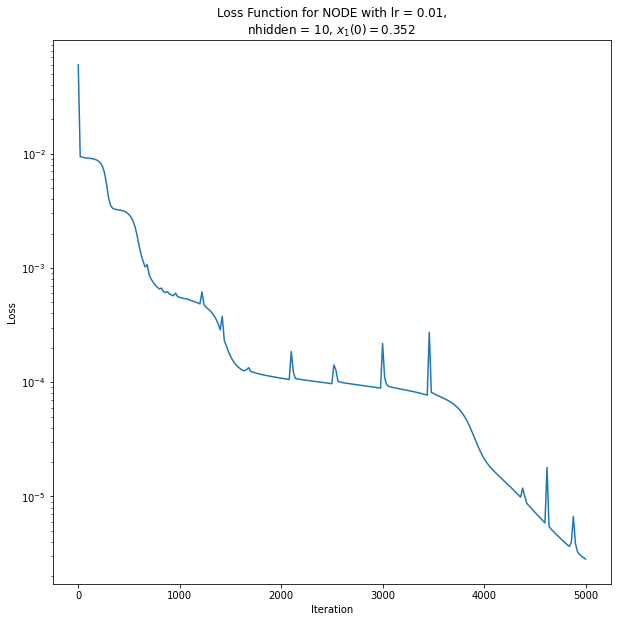

In [41]:
iters = []
losses = []
x_1 = true_y[:,0]
variation_number = 6
save = True
for item in loss_data:
  iters.append(item[0])
  losses.append(item[1])
plt.figure(figsize=[10,10])
plt.plot(iters, losses)
plt.title('Loss Function for NODE with lr = ' + str(args.lr) 
          + ',\nnhidden = ' + str(args.nhidden) + ', $x_1(0) = $' + str(np.around(x_1[0].item(), decimals=3)))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
if save:
  plt.savefig('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/damped_oscillators/experiment_0/loss_curve_'
  + str(variation_number) + '.pdf')
plt.show()

In [ ]:
torch.save(loss_data, '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/calculating_hessians'
                      + '/testing_on_simple_nodes/sinusoidal_curve/mse_loss'
                      + '/08_dims/loss_data.pt')

In [ ]:
#Create a plot of the loss curve.
itrs = []
data = []

for item in loss_data:
  itrs.append(item[0])
  data.append(item[1])

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 14})
plt.plot(itrs, data)
plt.title('Loss function\nGradient Descent'
          + '\nLearning Rate = 1e-3' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.savefig('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/calculating_hessians'
            + '/testing_on_simple_nodes/sinusoidal_curve/mse_loss'
            + '/08_dims/loss_curve.png')
plt.show()

In [ ]:
odeint()

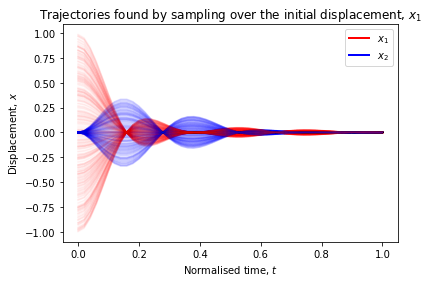

In [ ]:
# sanity plot
save = False

f = plt.figure()

for inputs, labels, times in train_loader:
    plt.plot(times[0], labels[0,:,0], alpha=0.03, c='r')
    plt.plot(times[0], labels[0,:,1], alpha=0.03, c='b')
plt.title('Trajectories found by sampling over the initial displacement, $x_1$')
custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2)]
plt.legend(custom_lines, ['$x_1$', '$x_2$'])
plt.xlabel('Normalised time, $t$')
plt.ylabel('Displacement, $x$')

if save: 
  f.savefig('varying_x_trajectories.pdf', bbox_inches='tight')

plt.show()